## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

For this project, i will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df.nunique()['user_id']

290584

d. The proportion of users converted.

In [5]:
df.query('converted == 1').count()['user_id']/ df.nunique()['user_id']

0.12126269856564711

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
ttt_not_new = df.query('group == "treatment" & landing_page != "new_page"')
ttt_not_new.count()['user_id']

1965

In [7]:
new_not_ttt = df.query('group != "treatment" & landing_page == "new_page"')
new_not_ttt.count()['user_id']

1928

In [8]:
ttt_not_new.shape[0] + new_not_ttt.shape[0]

3893

f. Do any of the rows have missing values?

In [9]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.

a. Creating a new dataset that drops the erroneous entries.  Store your new dataframe in **df2**.

In [10]:
df2 = df.drop(ttt_not_new.index)
df2 = df2.drop(new_not_ttt.index)

In [11]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** to investigate the following points:

a. How many unique **user_id**s are in **df2**?

In [12]:
df2.user_id.nunique()

290584

b. Detecting  **repeated user_ids** if any:

In [13]:
df2[df2.user_id.duplicated()].user_id

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [14]:
df2[df2.duplicated('user_id', keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Removing **one** of the rows with a duplicate **user_id**.

In [15]:
df2 = df2.drop_duplicates(subset='user_id', keep="last")

In [16]:
#Checking for sucessful removal
df2[df2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


`4.` Use **df2** to answer the following questions:

a. What is the probability of an individual converting regardless of the page they receive?

In [17]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [18]:
control_conv = df2.query('group=="control"').converted.mean()
control_conv

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
ttt_conv = df2.query('group=="treatment"').converted.mean()
ttt_conv

0.11880806551510564

d. What is the probability that an individual received the new page?

In [20]:
df2.query('landing_page =="new_page"').user_id.count() / df2.shape[0]

0.50006194422266881

Given the balanced proportions of each page, no adjustment is required to correct for impacts of uneven weights between the pages.

**From the above statistical figures, it seems there's no enough evidence that the new page is performing significantly better than the old in terms of conversions. **

<a id='ab_test'></a>
### Part II - A/B Test

`1.` For now, i am considering to make the decision just based on all the data provided.  I will assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%. Hence, in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages; the null and alternative hypotheses will be:

**$$H_0: p_{new} - p_{old} \leq 0 \\ H_{1}: p_{new} - p_{old} > 0$$**

`2.` Under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>
Using a sample size for each page equal to the ones in **ab_data.csv**. I will Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

SO, the **convert rate** for $p_{new}$ & $p_{old}$ under the null will be:

In [21]:
convert_rate = df2.converted.mean()
convert_rate

0.11959708724499628

Then $n_{new}$ & $n_{old}$ will bw calculated as follows: 

In [22]:
df2.groupby('landing_page').count().user_id

landing_page
new_page    145310
old_page    145274
Name: user_id, dtype: int64

In [23]:
n_new = df2.groupby('landing_page').count().user_id[0]
n_new

145310

In [24]:
n_old = df2.groupby('landing_page').count().user_id[1]
n_old

145274

Simulating $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Storing these $n_{new}$ 1's and 0's in **new_page_converted**.

In [25]:
new_page_converted = np.random.choice([0, 1], size=n_new, p=[(1-convert_rate), convert_rate])

Simulating $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Storing these $n_{old}$ 1's and 0's in **old_page_converted**.

In [26]:
old_page_converted = np.random.choice([0, 1], size=n_old, p=[(1-convert_rate), convert_rate])

Finding $p_{new}$ - $p_{old}$ for the simulated values.

In [27]:
new_page_converted.mean() - old_page_converted.mean()

0.0010577372160923831

Simulating 10,000 $p_{new}$ - $p_{old}$ values & storing all 10,000 values in **p_diffs**.

In [28]:
p_diffs = []

for _ in range(10000):
    new_page_converted = np.random.choice([0, 1], size=n_new, p=[(1-convert_rate), convert_rate])
    old_page_converted = np.random.choice([0, 1], size=n_old, p=[(1-convert_rate), convert_rate])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

Plotting a histogram of the **p_diffs**.

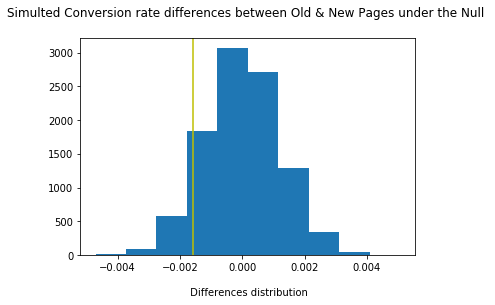

In [29]:
p_diffs = np.array(p_diffs)
plt.hist(p_diffs);
plt.title('Simulted Conversion rate differences between Old & New Pages under the Null \n')
plt.xlabel('\n Differences distribution')
plt.axvline(ttt_conv - control_conv, c = 'y');

What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [30]:
Obs_diff = ttt_conv - control_conv
pval = (p_diffs > Obs_diff).mean()
pval

0.9032

***The p-value claculated is 0.9055.*** This figure is really greater than the stated type 1 error probability or ($\alpha$) level of (0.05) under the null hypothesis. Consequently, we fail to reject the null hypothesis in favor of the alternative one as there's no sufficient evidence that the new page is a better performer then the old one.    

We could also use a ***built-in*** to achieve similar results.

In [31]:
import statsmodels.api as sm

# number of rows for old & new pges that led to conversions and the overall as calculated above
convert_old = df2.query('group=="control" & converted == 1').user_id.count()
convert_new = df2.query('group=="treatment" & converted == 1').user_id.count()
n_old = n_old
n_new = n_new

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Now using `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [32]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative = 'larger')
z_score, p_value

(-1.3109241984234394, 0.90505831275902449)

**The z-score and p-value are totally commensurate with what has been reached using the simulated differences above.** They confirmed that there's no enough evidence that the new page is a better performer then the old one.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, we will see that the result we acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, i will resort to:

***Logistic Regression.*** 

b. The goal is to use **statsmodels** to fit the regression model to see if there is a significant difference in conversion based on which page a customer receives.  However, i first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [33]:
df2['intercept']=1

df2[['ab_page', 'old_page']] = pd.get_dummies(df['landing_page'])
df2.head(3)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,old_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0


c. Use **statsmodels** to import regression model.  Instantiate the model, and fit the model using the two columns created in part **b.** to predict whether or not an individual converts.

In [34]:
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
result = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of the model below, and use it as necessary to answer the following questions.

In [35]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 02 Jul 2018   Pseudo R-squ.:               8.077e-06
Time:                        07:49:51   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br> 

The p-value associated with **ab_page** is 0.190,  which is still beyond the $\alpha$ level of 0.05. The difference from the above results is attributed to the hypotheses associated with the logistic regression model:
**$$H_0: p_{new} - p_{old} =0 \\ H_{1}: p_{new} - p_{old} \neq 0$$**

leading to a two tail test. Neverthless, We still cannot reject the null.

Here's a validation from the previously obtained results from simulation if it were two a tail test

In [36]:
lower_bound = (p_diffs < Obs_diff)
upper_bound = (p_diffs > p_diffs.mean() + (p_diffs.mean() - Obs_diff))

pval = lower_bound.mean() + upper_bound.mean()
pval

0.1888

f. Now, i am considering other things that might influence whether or not an individual converts.  Discussing why it is a good idea to consider other factors to add into my regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Taking multiple explanatory variables and using them at the same time to predict a response variable is definitly a good step to consider.** Yet, some of the challenges that might emerge are:

1. ***Choosing the right predictor variables;*** While it is tempting to include as many input variables as possible, this can dilute true associations and lead to large standard errors with wide and imprecise confidence intervals, or, conversely, identify spurious associations. The conventional technique is to first run the univariate analyses (i.e., relation of the outcome with each predictor, one at a time) and then use only those variables which meet a preset cutoff for significance to run a multivariable model.

2. ***Assumptions regarding the relationship between input and output variables.*** Regression models assume that the relationship between the predictor variables and the dependent variable is uniform, i.e., follows a particular direction – this may be positive or negative, linear or nonlinear but is constant over the entire range of values. This assumption may not hold true for certain associations

3. ***Avoiding the use of highly correlated variables;*** if input variables are highly correlated with one another (known as multicollinearity), then the effect of each on the regression model becomes less precise.

Ref: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5543767/

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. we will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?

In [37]:
# Reading the countries dataframe and joining to the original dataframe df2
countries_df = pd.read_csv('countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'))
print(df_new.shape) 
df_new.head()

(290584, 8)


,country,timestamp,group,landing_page,converted,intercept,ab_page,old_page
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0


In [38]:
# Obtaining information on countries
df_new['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [39]:
# Establishing the Dummy Variables for countries

df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
df_new.head(3)

,country,timestamp,group,landing_page,converted,intercept,ab_page,old_page,CA,UK,US
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0,1,0


In [40]:
# Model Instantiating and fitting
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'CA', 'UK']])
result = log_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Mon, 02 Jul 2018   Pseudo R-squ.:               1.521e-05
Time:                        07:49:52   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

***Findings***: As illustrated, the p-values reveals that - for the countries - there's no significant association with the two pages' conversion rates. So, again we fail to reject the null hypothesis. 

h. We have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

In [41]:
#Checking for interactions: 
df_new['CA_page'] = df_new['CA'] * df_new['ab_page']
df_new['UK_page'] = df_new['UK'] * df_new['ab_page']
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,old_page,CA,UK,US,CA_page,UK_page
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,0,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0,1,0,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0,1,0,0,1


In [42]:
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'CA', 'UK', 'CA_page', 'UK_page']])
result = log_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Mon, 02 Jul 2018   Pseudo R-squ.:               3.482e-05
Time:                        07:49:53   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
CA_page       -0.0469      0.054     -0.872      0.383      -0.152       0.059
UK_page        0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

***Findings:*** None of the p-values is significant. Consequently, we fail to reject the null. Finally, there is no sufficient evidence to suggest the existence of an interaction between user country and page received that will predict whether a user converts or not.

***In summary***, building on what we had, there is no sufficient evidence to suggest that the new page garners more conversions than the old one.

In [43]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0